### CHANGELOG  
### Done:  
Batch size 32 to 1  
Made x- and y-axis same size  
Student validation: catches if students amongst data are not identical  
Data import rewrittten, now pulling all .csv files from a given folder and initializing dataframes  
Initialized institutional data feature dataframe
Initializing clickstream feature dataframe  
### In Progress:  
Experiment w/ neural net depth, activation functions, loss, optimizations  
Neural net fitting  
Feature Importance 
### To Do:   
Demographics  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Male / Female  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1st Gen / Non  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;White / Other  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Underclass / Upperclass? (least important)  
Start splitting for train/test w/ week 11 and week 3/4  (regex?)
#### Data:  
Total Boxsand Clicks  
Total Syllabus Clicks  
Total Exam Access  
Total Solutions Access  
Total Practice Problems  
Total Calendar Access  
Total YouTube Access  
Video Score Breakdown  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Quartile Division  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sum Quartile  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Avg var after sum  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Quartile Weight?  
Prelab + Lab?  
Total Openstax Access  

In [1]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import glob
import re
np.random.seed(0)

path = r'C:\Users\OSU_bailderr\Box\Anon Data\Undergrad Students\Derrick Bailey\NN Data'
file = glob.glob(os.path.join(path, "*.csv"))
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

dfs = []
for f in file:
    df = pd.read_csv(f)
    dfs.append(df)
dfs = np.array(dfs, dtype=object)
    
institutional_Data = dfs[0]

gradebook = dfs[1]

clickstream1 = dfs[2] 
clickstream2 = dfs[3]

headers = list(clickstream1)
clickstream2.columns = headers
clickstream = pd.concat([clickstream1, clickstream2], ignore_index=False)

institutional_Data_Students = institutional_Data['ID'].unique()
institutional_Data_Students = pd.DataFrame(institutional_Data_Students)
institutional_Data_Students = institutional_Data_Students.dropna(axis=0, how='all')
institutional_Data_Students.columns = ['ID']
# print(institutional_Data_Students)

gradebook_Students = gradebook['ID'].unique()
gradebook_Students = pd.DataFrame(gradebook_Students)
gradebook_Students = gradebook_Students.dropna(axis=0, how='all')
gradebook_Students.columns = ['ID']
# print(gradebook_Students)

clickstream_Students = clickstream['ID'].unique()
clickstream_Students = pd.DataFrame(clickstream_Students)
clickstream_Students = clickstream_Students.dropna(axis=0, how='all')
clickstream_Students.columns = ['ID']
# print(clickstream_Students)

#delete students in clickstream and institutional if not present in gradebook
institutional_Data_Students = institutional_Data_Students[institutional_Data_Students.ID.isin(gradebook_Students.ID)].dropna()
clickstream_Students = clickstream_Students[clickstream_Students.ID.isin(gradebook_Students.ID)].dropna()
# print(institutional_Data_Students)
# print(clickstream_Students)

#check that students in institutional_Data match students in clickstream
class StudentError(Exception):
    pass
try:
    student_Check = clickstream_Students.iloc[:,0].str.strip().str.lower().unique().all() == institutional_Data_Students.iloc[:,0].str.strip().str.lower().unique().all() == gradebook_Students.iloc[:,0].str.strip().str.lower().unique().all()
    if student_Check != True:
        raise StudentError
except StudentError:
    print("Students in Dataframes do not match!")
    assert False
except(SyntaxError):
    print("Syntax Issue!")
    assert False
    
#Parse through Institutional Data to generate featureset
institutional_Data_cols = list(institutional_Data.columns)
# drop any and all columns that are all ZERO (necessary: columns of zeroes will influence weighting and prediction)
institutional_Data = institutional_Data.loc[:, (institutional_Data !=0).any(axis=0)]
# drop any and all columns that are all NaN (necessary step - matrix operation on NaN will result in all operations NaN)
institutional_Data = institutional_Data.dropna(axis=1, how='all')
# fill NaN with zeroes
institutional_Data = institutional_Data.fillna(0)
institutional_Data = institutional_Data[institutional_Data.ID.isin(institutional_Data_Students.ID)]

institutional_Data_Features = ["ID","OVERALL OSU GPA","OSU GPA","OSU CREDITS ATTEMPT","OSU CREDITS EARNED"]
institutional_Data = institutional_Data.loc[:, institutional_Data_Features].copy()
# institutional_Data

#Parse through Gradebook Data to generate featureset
gradebook_cols = list(gradebook.columns)
#feature list for gradebook
gradebook_features = ['ID', 'raw','online','HW%','RW%','Rec %','Lab %','M1%','M2%','Final%','Overall Grade %']
gradebook = gradebook[gradebook_features]
final_Grade = gradebook['Overall Grade %']
final_Grade = pd.DataFrame([final_Grade]).T
final_Grade = final_Grade.values
final_Grade = pd.DataFrame(final_Grade)
# remove final grade from gradebook
del gradebook['Overall Grade %']
# drop any and all columns that are all ZERO (necessary: columns of zeroes will influence weighting and prediction)
gradebook = gradebook.loc[:, (gradebook !=0).any(axis=0)]
# drop any and all columns that are all NaN (necessary step - matrix operation on NaN will result in all operations NaN)
gradebook = gradebook.dropna(axis=1, how='all')
# fill NaN with zeroes
gradebook = gradebook.fillna(0)
# recatch cols var
cols = list(gradebook.columns)

gradebook = gradebook[gradebook.ID.isin(gradebook_Students.ID)]

#Parse through Clickstream Data to generate featureset
clickstream_cols = list(clickstream.columns)
clickstream.set_index=clickstream['ID']
# drop any and all columns that are all ZERO (necessary: columns of zeroes will influence weighting and prediction)
clickstream = clickstream.loc[:, (clickstream !=0).any(axis=0)]
# drop any and all columns that are all NaN (necessary step - matrix operation on NaN will result in all operations NaN)
clickstream = clickstream.dropna(axis=1, how='all')
# fill NaN with zeroes
clickstream = clickstream.fillna(0)

clickstream = clickstream[clickstream.ID.isin(clickstream_Students.ID)]

# now to parse through for specific features
# create list out of student column
student_list = clickstream[['ID']]
# print(student_list)
student_list_unique = pd.DataFrame(student_list['ID'].unique())
student_list_unique.columns = ['ID']
# display(student_list_unique)

clickstream_features = ['m1_sols', 'm2_sols','f_sols', '#Practice', '#Fundamental', 'Calendar', 'KALTURA']

clickstream_cut = clickstream[clickstream['Page title'].str.contains("|".join(clickstream_features))]

studentdf = []
studentdf = [x for _, x in clickstream_cut.groupby(by='ID')]

clickstream_Data = []
clickstream_Data = pd.DataFrame(columns = clickstream_features)
clickstream_Data = student_list_unique.append(clickstream_Data)

count = []
# manual feature-by-feature approach
# for pos in df:
#     for ID in pos['ID'].unique():
#         ID = pos['ID'].unique()
#         count.append(pos['Page title'].str.contains('m1_sols').sum())
# print(count)
# count = pd.DataFrame(count)
# print(count)
# featureframe = featureframe.assign(m1_sols = count)
# featureframe

#automated feature-by-feature approach
for feature in clickstream_features:
    for pos in studentdf:
        for ID in pos['ID'].unique():
#             if feature == "YouTube":
#                 count.append(pos['Referrer'].str.contains(feature).sum())
#             print(feature)
            ID = pos['ID'].unique()
            count.append(pos['Page title'].str.contains(feature).sum())
#             print(count)
    clickstream_Data[feature] = count
    count.clear()
# featureframe

# display(institutional_Data)
# display(gradebook)
# display(clickstream_Data)
# test = pd.concat([institutional_Data, gradebook], axis=1)

frames = pd.merge(institutional_Data, gradebook, on='ID')
frames = pd.merge(frames, clickstream_Data, on='ID')

input_Features = frames
feature_num = len(input_Features.columns)
# display(input_Features)

In [2]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(data)

In [3]:
#### debug
# debug_input = "N"
# debug_input = str(input("Debug? Y/N \n"))

# while debug_input == "Y":
#     debug_input2 = int(input("Invoke the rite of passage! \n \
#     1: Final Grades Dataframe \n \
#     2: Student Dataframe \n \
#     3: Input Features Dataframe \n \
#     4: Exit \n"))
#     if debug_input2 == 1:
#         print("Final Grades Dataframe")
#         display(final_Grade)
#         break
#     elif debug_input2 == 2:
#         print("Student Dataframe")
#         display(students)
#         break
#     elif debug_input2 == 3:
#         print("Input Features Dataframe")
#         display(input_Features)
#         break
#     elif debug_input2 == 4:
#         debug_input = "N"
#         break
#     else:
#         print("Invalid input")

In [4]:
# Split data for train/test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_Features, final_Grade, test_size=0.3, random_state=0)
# test
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# delete student column before normalization but saving student column
x_train_student = x_train[:,0]
x_test_student = x_test[:,0]
x_train = np.delete(x_train, 0, 1)
x_test = np.delete(x_test, 0, 1)
# y_train = np.delete(y_train, 0, 1)
# y_test = np.delete(y_test, 0, 1)

In [5]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.fit_transform(x_test)
y_train_norm = sc.fit_transform(y_train)
y_test_norm = sc.fit_transform(y_test)

x_train_norm = np.reshape(x_train_norm, (x_train_norm.shape[0], x_train_norm.shape[1], 1))
x_test_norm = np.reshape(x_test_norm, (x_test_norm.shape[0], x_test_norm.shape[1], 1))

In [20]:
#new model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

tf.random.set_seed(0)
tf.keras.backend.set_floatx('float64')
with tf.device('/cpu:0'):
    # NN Parameters
    run_type = input("Enter run type: Full, Test")
    if run_type == "Full":
        num_units = 50
        rec_drop = 0.2
        drop = 0.2
        opt = 'Adam'
        loss = 'mse'
        num_epoch = 750
        batch_size = 1

    if run_type == "Test":
        num_units = 50
        rec_drop = 0.2
        drop = 0.2
        opt = 'Adam'
        loss = 'mse'
        num_epoch = 100
        batch_size = 64

    # Initialization
    RNN = Sequential()
    import time
    start = time.perf_counter()
    # 1st LSTM layer & Dropout regularisation
    RNN.add(LSTM(units=num_units, return_sequences=True, recurrent_dropout=rec_drop, input_shape=(x_train_norm.shape[1],1)))
    RNN.add(Dropout(drop))
    # 2nd LSTM Layer & Dropout regularisation
    RNN.add(LSTM(units=num_units, return_sequences=True, recurrent_dropout=rec_drop))
    RNN.add(Dropout(drop))
    # 3rd LSTM Layer & Dropout regularisation
    RNN.add(LSTM(units=num_units, return_sequences=True, recurrent_dropout=rec_drop))
    RNN.add(Dropout(drop))
    # 4th LSTM Layer & Dropout regularisation
    RNN.add(LSTM(units=num_units, recurrent_dropout=rec_drop))
    RNN.add(Dropout(drop))
    # Output Layer
    RNN.add(Dense(units = 1))
    # Compiling RNN
    RNN.compile(optimizer=opt, loss=loss)

    #Early Stop Callback
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=25)

    # Fitting RNN to training set
    fit = RNN.fit(x_train_norm, y_train_norm, epochs = num_epoch, batch_size = batch_size, validation_split=0.15, validation_data=None, callbacks=[early_stop], shuffle=True)
    print(RNN.summary())
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

# Evaluate mode
# history = RNN.evaluate(x_test_norm, y_test_norm, batch_size = 1)

# Predicted Grade
predicted_Grade = RNN.predict(x_test_norm)
# predicted_Grade_Dataset = np.zeros(shape=(len(predicted_Grade), 10))
# predicted_Grade_Dataset[:,0] = predicted_Grade[:,0]
predicted_Grade = sc.inverse_transform(predicted_Grade)[:,0]
predicted_Grade = np.vstack((x_test_student, predicted_Grade))
predicted_Grade = predicted_Grade.T
predicted_Grade = pd.DataFrame(predicted_Grade)

Enter run type: Full, Test Test


Train on 210 samples, validate on 38 samples
Epoch 1/100
210/210 [==============================] - 6s 30ms/sample - loss: 0.4238 - val_loss: 0.1573
Epoch 2/100
210/210 [==============================] - 0s 1ms/sample - loss: 0.0909 - val_loss: 0.1024
Epoch 3/100
210/210 [==============================] - 0s 1ms/sample - loss: 0.0778 - val_loss: 0.0134
Epoch 4/100
210/210 [==============================] - 0s 1ms/sample - loss: 0.0370 - val_loss: 0.0398
Epoch 5/100
210/210 [==============================] - 0s 1ms/sample - loss: 0.0401 - val_loss: 0.0176
Epoch 6/100
210/210 [==============================] - 0s 1ms/sample - loss: 0.0210 - val_loss: 0.0188
Epoch 7/100
210/210 [==============================] - 0s 994us/sample - loss: 0.0295 - val_loss: 0.0179
Epoch 8/100
210/210 [==============================] - 0s 959us/sample - loss: 0.0239 - val_loss: 0.0134
Epoch 9/100
210/210 [==============================] - 0s 961us/sample - loss: 0.0232 - val_loss: 0.0157
Epoch 10/100
210/210 

In [53]:
for i in range(len(RNN.layers)):
    print(
    RNN.layers[i].weights,
#     RNN.layers[i].bias.numpy()
    )

[<tf.Variable 'lstm_8/kernel:0' shape=(1, 200) dtype=float64, numpy=
array([[-0.07118879, -0.06616596, -0.01384402,  0.16743133,  0.02652377,
         0.07452268,  0.05973078, -0.03192857, -0.06460921,  0.05348536,
        -0.1210123 ,  0.13853803,  0.03013757, -0.1371415 , -0.0081038 ,
        -0.02806148, -0.03503715, -0.01259522,  0.08641664, -0.04608161,
         0.12440499, -0.01935819,  0.16282194, -0.05919913,  0.01288385,
         0.08157308,  0.02151346, -0.01361647,  0.07001883,  0.04561882,
        -0.006784  ,  0.11450637, -0.11860444,  0.0132583 ,  0.07322805,
        -0.09714397,  0.15822193, -0.12055487,  0.06516404,  0.12828961,
         0.0480876 ,  0.10808818,  0.09687475,  0.15359105,  0.08342605,
        -0.04318265, -0.1603137 ,  0.01998425,  0.10543411, -0.08995386,
        -0.07989476,  0.028065  ,  0.10633073,  0.14756416, -0.14998769,
        -0.0573949 , -0.03703098,  0.01996509,  0.04267236,  0.07566801,
         0.02554499,  0.12914377, -0.12293523, -0.14556

In [25]:
# Predicted Grade
predicted_Grade = RNN.predict(x_test_norm)
# predicted_Grade_Dataset = np.zeros(shape=(len(predicted_Grade), 10))
# predicted_Grade_Dataset[:,0] = predicted_Grade[:,0]
predicted_Grade = sc.inverse_transform(predicted_Grade)[:,0]
predicted_Grade = np.vstack((x_test_student, predicted_Grade))
predicted_Grade = predicted_Grade.T
predicted_Grade = pd.DataFrame(predicted_Grade)

In [26]:
# First, we must cross-reference the split data with the final grade master list
# and pull only the matching student numbers from the final grade master list.

# Start by zipping together student dataframe and final grade dataframe.
final_Grade = np.hstack((student_list_unique, final_Grade))
final_Grade = pd.DataFrame(final_Grade)
# To make our lives easy, let's name the columns for our predicted and final grade dataframes.
final_Grade.columns = ['FStudent','FGrade']
predicted_Grade.columns = ['PStudent','PGrade']
# Now, we compare the student columns for these dataframes.
merged_Grades = final_Grade.merge(predicted_Grade, left_on = 'FStudent', right_on = 'PStudent', how = 'left')
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(merged_Grades)
merged_Grades = merged_Grades[merged_Grades['PStudent'].notna()]

In [27]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(merged_Grades)

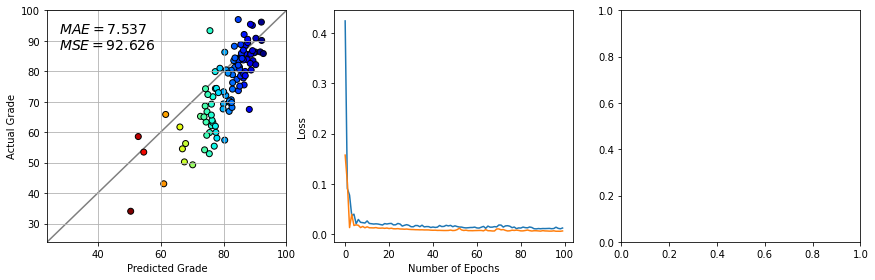

In [46]:
# Visualize the chaos
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.scatter(merged_Grades.iloc[:,3],merged_Grades.iloc[:,1], c=merged_Grades.iloc[:,3], cmap = 'jet_r', edgecolors='black')
ax1.set_xlabel('Predicted Grade')
ax1.set_ylabel('Actual Grade')
min_predicted = merged_Grades['PGrade'].min()
min_actual = merged_Grades['FGrade'].min()
min_val = [min_predicted, min_actual]
min_val = min(min_val)
min_val = round(min_val, 0)
ax1.set_xlim(min_val-10,100)
ax1.set_ylim(min_val-10,100)


loss_df = pd.DataFrame(RNN.history.history)
ax2.plot(loss_df[['loss', 'val_loss']])
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Loss")
# ax2.plot(fit.history['accuracy'], label = 'train')
# ax2.plot(fit.history['val_accuracy'], label = 'test')
# ax2.legend()

#compute MAE & MSE
mae = tf.keras.losses.MeanAbsoluteError()
#write MAE from scratch, compare to tf
mse = tf.keras.losses.MeanSquaredError()
mae = mae(merged_Grades.iloc[:,3],merged_Grades.iloc[:,1]).numpy()
mse = mse(merged_Grades.iloc[:,3],merged_Grades.iloc[:,1]).numpy()
textstr = '\n'.join((
    r'$MAE = %1.3f$' %mae,
    r'$MSE = %1.3f$' %mse))

ax1.text(0.05, 0.95, textstr, transform = ax1.transAxes, fontsize = 14, va = 'top')

lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

lims2 = [
     np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
     np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
ax1.plot(lims1, lims1, 'k-', alpha=0.5, zorder=0)
# figname = input('Graph name: ')
# fig.savefig("{}.svg".format(figname), transparent=False, facecolor = 'w')
# fig.savefig("{}.png".format(figname), transparent=False, facecolor = 'w')

# ax2.bar([x for x in range(len(importance))], importance)
# ax2.plot(lims, lims)

arr_predictions = np.array[x[0] for x in ]

ax1.grid()
fig.tight_layout()
fig.subplots_adjust(right=2, wspace=0.2)
# plt.show()

Text(0, 0.5, 'Loss')

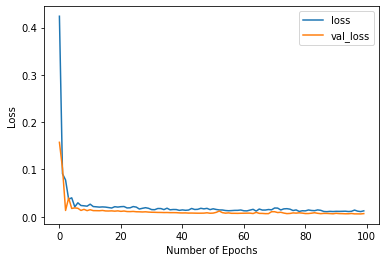

In [17]:
### Feature Importance


TypeError: 'numpy.bool_' object is not iterable

In [ ]:
savegraph = input('Do you want to save this graph? Y/N: ')
if savegraph == "Y":
    figname = input('Graph name: ')
    fig.savefig("{}.svg".format(figname), transparent=False, facecolor = 'w', dpi=150)
    fig.savefig("{}.png".format(figname), transparent=False, facecolor = 'w', dpi=150)

In [ ]:
display_Students = input("Display students? Y/N: ")
display_Students.upper()
if display_Students == "Y":
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(merged_Grades)